# CitiBike Destination Predictor

This project is a collaboration between [Elena Morais](https://github.com/elenasm7) and [Derrick Lewis](https://github.com/lewi0332)

The project requirements are to find and clean data to be fit to a classification algorithm to make predictions on the outcome. 

We chose to use data from CitiBike of all trips in 2018. This data includes time, start/stop locations, and some basic demographic identifiers. To aid in our perdiction we added daily weather information of New York City. 

- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth

The goal is to perdict the destination neighborhood of each journey based on the available variables. This is a multi-classification problem with a high number of outcomes. We determined that there are 51 qualifying neighborhoods in New York, which presents a sigificant challenge. 


## Data Collection and Cleaning

First we collected 1 year worth of trip data from Cibibike.com. We learn that there are 17million records in the 2018 data, which is too large for our processing capbabilities. Thus we import each month of data, and randomly sample 10% from each month to create a more manageable, yet representative list. 

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from citibike_scripts import *
np.random.seed(0)
%matplotlib inline

In [4]:
def all_files_to_df(num,start_file_path, end_file_path):
    '''
    this function takes in length of the list of files (+1) and the beginning and end of the file's names,
    it then reads in all the files and concatinates them into a single dataframe.
    '''
    df_li = []
    for i in range(1,num):
        df_li.append(pd.read_csv(start_file_path+ str(i).zfill(2)+end_file_path).sample(frac=.1,random_state=42))
    return pd.concat(df_li)

In [6]:
citibikes_df = all_files_to_df(13,'../citibike_data/2018', '-citibike-tripdata.csv')

In [7]:
citibikes_df.shape

(1754832, 15)

In [8]:
citibikes_df.to_csv('test_data.csv')

### Null values

There are just 295 NaN values missing the station start and end points in the file of nearly 1.8million. This information is crucial to the prediction and thus can not be substituted. We have decidied to simply remove these rows. 

In [9]:
citibikes_df.isnull().sum()

tripduration                 0
starttime                    0
stoptime                     0
start station id           295
start station name         295
start station latitude       0
start station longitude      0
end station id             295
end station name           295
end station latitude         0
end station longitude        0
bikeid                       0
usertype                     0
birth year                   0
gender                       0
dtype: int64

In [12]:
citibikes_df.dropna(inplace=True) #drops rows with missing data, axis default to 0.
citibikes_df.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

### Convert to DateTime 

Start and End times are saved in a format that is not readable by Pandas or our future models. We will convert the columns with this information into a standard date format, then split the relevant information into individual columns to be used as a specific independant variable.

In [13]:
citibikes_df['starttime'] = pd.to_datetime(citibikes_df['starttime'])
citibikes_df['start_month'] = citibikes_df.starttime.dt.month
citibikes_df['start_day_of_week'] = citibikes_df.starttime.dt.dayofweek
citibikes_df['start_hour'] = citibikes_df.starttime.dt.hour
citibikes_df['start_date'] = citibikes_df.starttime.dt.day

citibikes_df['starttime'] = citibikes_df.starttime.dt.date
citibikes_df['starttime'] = pd.to_datetime(citibikes_df['starttime'])


In [14]:
citibikes_df.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,start_month,start_day_of_week,start_hour,start_date
318178,592,2018-01-22,2018-01-22 08:12:31.2680,478.0,11 Ave & W 41 St,40.760301,-73.998842,505.0,6 Ave & W 33 St,40.749013,-73.988484,33395,Subscriber,1986,1,1,0,8,22
383962,450,2018-01-03,2018-01-03 10:07:56.2390,509.0,9 Ave & W 22 St,40.745497,-74.001971,474.0,5 Ave & E 29 St,40.745168,-73.986831,29115,Subscriber,1981,1,1,2,10,3


### Insert Weather Data Here: 

https://www.weather.gov/okx/centralparkhistorical

Next we connect daily weather information. The hypothesis is that this may aide in predicting a destination as fair weather might increase trips to parks and beaches. 

In [16]:
weather_df = pd.read_csv('../citibike_data/2018_weather.csv')
weather_df['starttime'] = pd.to_datetime(weather_df['date'])
weather_df = weather_df.drop(['max_temp', 'min_temp','departure', 'Hdd', 'cdd', 'new_snow', 'date' ], axis=1)                                               

In [17]:
citibikes_df = pd.merge(citibikes_df, weather_df, on='starttime', how='left')

In [19]:
citibikes_df.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,start_month,start_day_of_week,start_hour,start_date,ave_temp,precip,snow_depth
0,592,2018-01-22,2018-01-22 08:12:31.2680,478.0,11 Ave & W 41 St,40.760301,-73.998842,505.0,6 Ave & W 33 St,40.749013,...,Subscriber,1986,1,1,0,8,22,43.5,0.01,0
1,450,2018-01-03,2018-01-03 10:07:56.2390,509.0,9 Ave & W 22 St,40.745497,-74.001971,474.0,5 Ave & E 29 St,40.745168,...,Subscriber,1981,1,1,2,10,3,23.0,0.00,0


### Insert Neighborhood Name

Connect Neighborhood name data to our 'End Station Latitude/Longitude' to use as labels for predictions. In the most widely used context there are 51 neighborhoods in New York City. 

In [ ]:
#set the token and submit it
from mapbox import Geocoder
token = 'your_token_here'

#following two functions were defined in citibike_scripts
geocoder = Geocoder(access_token=token) 

end_neighborhoods = add_neighborhoods(big,'end')
start_neighborhoods = add_neighborhoods(big,'start')

In [20]:
end_neighborhoods = pd.read_csv('../citibike_data/end_neighborhoods.csv')
start_neighborhoods = pd.read_csv('../citibike_data/start_neighborhoods.csv')

Merge our stop Neighborhoods to the big DataFrame

In [22]:
citibikes_df = pd.merge(citibikes_df, end_neighborhoods, on='end station name', how='left')

__Lets get a set list of the missing end neighborhood station names__

By this we can see that 483 unique stops are not being matched to a neighborhood.

In [35]:
miss_end = list(set(citibikes_df[citibikes_df.end_nhbr.isnull()]['end station name']))
len(miss_end)

An error occured with matching, so lets's determine which neighborhoods are missing

In [39]:
non_match_ends = pd.DataFrame(list(citibikes_df[citibikes_df.end_nhbr.isnull()]['end station name']))
non_match_ends.rename(columns={0:'end station name'},inplace=True)

In [40]:
matching = pd.merge(non_match_ends,end_neighborhoods, on='end station name', how='left')

In [47]:
matching.drop_duplicates().isnull().sum()

end station name           0
end station latitude     429
end station longitude    429
end_nhbr                 429
dtype: int64

In [49]:
len(set(matching.drop_duplicates()['end station name']))

483

It looks like a majority of the missing values are in our original end neighborhood DataFrame. So, lets get the latitude and longitudes from the missing values in big and create a dataframe of the set of those.

In [ ]:
missing_stops = pd.DataFrame(list(set(zip(citibikes_df[citibikes_df.end_nhbr.isnull()]['end station latitude'],citibikes_df[citibikes_df.end_nhbr.isnull()]['end station longitude']))))
missing_stops.rename(columns={0:'end station latitude',1:'end station longitude'},inplace=True)
missing_stops['end_nhbr'] = missing_stops.apply(lambda row: get_neighborhood(row,'end'), axis=1)
# missing_stops.to_csv('citibike_data/missing_end_neighborhoods.csv')

In [61]:
citibikes_df_ends = pd.merge(citibikes_df, missing_stops, on=['end station latitude','end station longitude'], how='left')

In [104]:
citibikes_df_ends['end_nhbr'] = citibikes_df_ends.apply(lambda row: fix_neighborhood(row,'end'), axis=1)

In [109]:
citibikes_df_ends.drop(['end station name_y', 'end_nhbr_x', 'end_nhbr_y',
                       'end station id', 'end station name_x',
                       'end station latitude', 'end station longitude'],axis=1,inplace=True)

In [110]:
citibikes_df_ends.to_csv('updated_citibike_data_w_ends.csv')

In [198]:
citibikes_df_ends = citibikes_df_ends[~citibikes_df_ends.end_nhbr.str.contains('NaN')]

Ok, we will __not__ drop the uneeded columns yet. We will do this after creating the start neighborhood for our second dataset.

_Great!_ We now have all the missing neighborhoods. We just dropped the unneeded columns and saved the file.

We merged the start neighborhoods with big, and saw a bunch of null values for start neighborhoods as well. So, we processed the steps from above.

In [113]:
citibikes_df_2 = pd.merge(citibikes_df_ends, start_neighborhoods, on='start station name', how='left')

In [ ]:
non_match_starts = pd.DataFrame(list(citibikes_df_2[citibikes_df_2.start_nhbr.isnull()]['start station name']))
non_match_starts.rename(columns={0:'start station name'},inplace=True)

In [ ]:
missing_starts = pd.DataFrame(list(set(zip(citibikes_df_2[big_2.start_nhbr.isnull()]['start station latitude'],citibikes_df_2[citibikes_df_2.start_nhbr.isnull()]['start station longitude']))))
missing_starts.rename(columns={0:'start station latitude',1:'start station longitude'},inplace=True)
missing_starts['start_nhbr'] = missing_starts.apply(lambda row: get_neighborhood(row,'start'), axis=1)
missing_starts.to_csv('citibike_data/missing_start_neighborhoods.csv')

In [194]:
# citibikes_df_2.isnull().sum()

In [121]:
citibikes_df_2.rename(columns={'start station latitude_x':'start station latitude','start station longitude_x':'start station longitude'},inplace=True)

In [122]:
citibikes_df_nhbrs = pd.merge(citibikes_df_2, missing_starts, on=['start station latitude','start station longitude'], how='left')


In [128]:
citibikes_df_nhbrs.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'bikeid', 'usertype', 'birth year', 'gender',
       'start_month', 'start_day_of_week', 'start_hour', 'start_date',
       'ave_temp', 'precip', 'snow_depth', 'end_nhbr',
       'start station latitude_y', 'start station longitude_y', 'start_nhbr_x',
       'start_nhbr_y'],
      dtype='object')

In [130]:
citibikes_df_nhbrs['start_nhbr'] = citibikes_df_nhbrs.apply(lambda row: fix_neighborhood(row,'start'), axis=1)

In [133]:
citibikes_df_nhbrs.drop(['start station latitude_y', 'start station longitude_y', 
                         'start_nhbr_x','start_nhbr_y','start station id',
                         'start station name','start station latitude',
                         'start station longitude'],axis=1,inplace=True)

After we do this we can see that there are 104583 'NaN' values for the start neighborhoods and 470980 for end neighborhoods. We will drop these, as they only make up ~ 5% of our data. 

This is _not ideal_, but the best thing for this case.

In [188]:
citibikes_df_nhbrs = citibikes_df_nhbrs[~citibikes_df_nhbrs.start_nhbr.str.contains('NaN')]
citibikes_df_nhbrs = citibikes_df_nhbrs[~citibikes_df_nhbrs.end_nhbr.str.contains('NaN')]
# citibikes_df_nhbrs.to_csv('../citibike_data/citibike_data_with_start_and_stop.csv')

Finally, drop the unneeded columns from our first dataframe:

In [209]:
citibikes_df_ends = pd.read_csv('../citibike_data/updated_citibike_data_w_ends.csv')
citibikes_df_ends = citibikes_df_ends[~citibikes_df_ends.end_nhbr.str.contains('What')]

In [202]:
citibikes_df_ends.drop(['start station name', 'start station latitude',
       'start station longitude'],axis=1,inplace=True)

/Users/elenasm7/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Convert usertype to categories

Our CitiBike data includes a label for each trip to determine if it was made by a rider who is an annual subscriber or someone who has purchased a temporary pass. We assume that there may be destinations more likely chosen by tourist users. 

In [212]:
citibikes_df_ends.usertype = pd.Categorical(citibikes_df_ends.usertype)
citibikes_df_ends.usertype = citibikes_df_ends.usertype.cat.codes

In [207]:
citibikes_df_nhbrs.usertype = pd.Categorical(citibikes_df_nhbrs.usertype)
citibikes_df_nhbrs.usertype = citibikes_df_nhbrs.usertype.cat.codes

### Exploring Age Data

after individually looking at column distributions, there were a few interestings observations with the age data.
Lets look into this below:

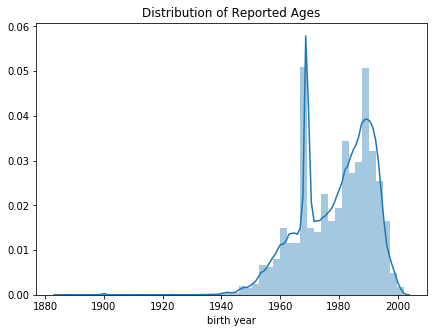

In [217]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
sns.distplot(citibikes_df_ends['birth year'])
plt.title('Distribution of Reported Ages');
# plt.savefig('original_age_dist.png')

The easit thing to handle: people born way too early. We've set a cut-off age of 80. Only __0.13%__ is from people saying they were born before 1939. If you look at the data above, these all seem pretty unrealistic, so lets __drop these values.__

In [224]:
citibikes_df_ends[citibikes_df_ends['birth year'] <= 1939].shape
# citibikes_df_nhbrs[citibikes_df_nhbrs['birth year'] <= 1939].shape

(4347, 16)

In [226]:
round(citibikes_df_ends[citibikes_df_ends['birth year'] <= 1939].shape[0]/citibikes_df_ends.shape[0] * 100,2)
# round(citibikes_df_nhbrs[citibikes_df_nhbrs['birth year'] <= 1939].shape[0]/citibikes_df_nhbrs.shape[0] * 100,2)

0.13

In [227]:
citibikes_df_ends.drop(list(citibikes_df_ends[citibikes_df_ends['birth year'] <= 1939]['birth year'].index),inplace=True)
citibikes_df_nhbrs.drop(list(citibikes_df_nhbrs[citibikes_df_nhbrs['birth year'] <= 1939]['birth year'].index),inplace=True)

### the youngest riders would need to be born in 2003, so we check for any riders claiming to be born after that

In [229]:
citibikes_df_ends['birth year'].max()
citibikes_df_nhbrs['birth year'].max()

2002

### Smooth '1969' birth year


In [230]:
def change_birth_year(row,med_age_df):
    '''
    This function will be applied to each row, where ever there is a 1969 we will replace it with the birth year 
    from median_birthyear_no_69 which matches with our stop neighborhood
    '''
    if row['birth year'] == 1969:
        year = med_age_df[med_age_df['end_nhbr']== row['end_nhbr']]['birth year']
        return year.item()
    else:
        return row['birth year']

Create dataframes of the median birth year by stop neighborhood

In [231]:
median_birthyear = pd.DataFrame(citibikes_df_ends.groupby('end_nhbr')['birth year'].median())
median_birthyear.reset_index(inplace=True) 
# median_birthyear.head()

In [232]:
median_birthyear_2 = pd.DataFrame(citibikes_df_nhbrs.groupby('end_nhbr')['birth year'].median())
median_birthyear_2.reset_index(inplace=True) 
# median_birthyear.head()

In [233]:
citibikes_df_ends['update_birth_yr_2'] = citibikes_df_ends.apply(lambda row: change_birth_year(row,median_birthyear),axis=1)
citibikes_df_nhbrs['update_birth_yr_2'] = citibikes_df_nhbrs.apply(lambda row: change_birth_year(row,median_birthyear_2),axis=1)

Create a displot of the fixed birth year column:

Text(0.5,1,'Distribution of Reported Ages w/o 1969')

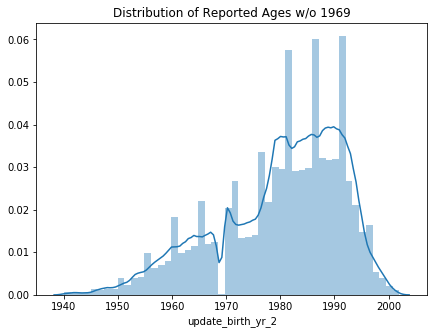

In [235]:
fig = plt.figure(figsize=(7,5))
sns.distplot(citibikes_df_ends['update_birth_yr_2'])
plt.title('Distribution of Reported Ages w/o 1969')
# plt.savefig('fixed_age_dist.png')

Text(0.5,1,'Distribution of Reported Ages w/o 1969')

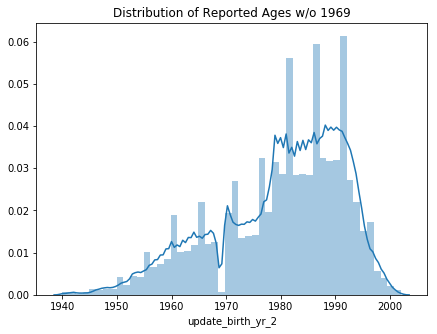

In [236]:
fig = plt.figure(figsize=(7,5))
sns.distplot(citibikes_df_nhbrs['update_birth_yr_2'])
plt.title('Distribution of Reported Ages w/o 1969')
# plt.savefig('fixed_age_dist.png')

### Bin Age into Categories

### Label Encode for Morning versus Evening. 

To better fit a model, using a split day rather than by hour might aide in determining a destination. The idea is that many nieghborhoods are destinations for commuters going to work in the morning and alternatively heading home in the evening. 

### Remove redundant rows - 

Now that our primary categories are set we will remove features that are not needed or redundant. 

In [ ]:
citibikes_df = citibikes_df.drop(['tripduration', 'starttime', 'stoptime','start station name',
                'end station id', 'bikeid', 'start station latitude', 
                'start station longitude', 'end station latitude', 
                'end station longitude','end station name', 'start_date'], axis=1)

### Save to CSV file to be used in later models 

In [ ]:
#citibikes_df.to_csv('citibike_2018.csv', index=False)

### View Correlation between varibles. 

In [ ]:
sns.pairplot(df_small)

### View the Volume of stop Neighborhoods.

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(df_small.stop_nhbr)
plt.xticks(rotation=90)